In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


null 은 없지만 datetime 만은 object 타입이다. datetime칼럼을 년, 월,일 ,시간 단위로 쪼개 새로 컬럼을 만든다

In [3]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [4]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

kaggle 에서 요구한 성능 평가 방법은 RMSLE 이므로 RMSLE, MAE, RMSE 성능 평가 함수를 만든다.

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle (y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) **2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

#MAE RMSE RMSLE 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE:{1:.3f}, MAE:{2:.3f}'.format(rmsle_val, rmse_val, mae_val))

다양한 회귀모델을 적용해 예측 성능을 측정한다.

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1, inplace=False)

X_train,X_test,y_train,y_test = train_test_split(X_features, y_target, test_size=0.3,
                                                random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred= lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE:140.900, MAE:105.924


실제 값과 예측값이 어느정도 차이가 나는지 오류값이 가장 큰 순 5개만 확인하겠다.

In [7]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])
    
    print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test,pred,5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


예측 오류가 매우 크다. 먼저 target 값의 분포도를 살펴봐야 한다.

<AxesSubplot:>

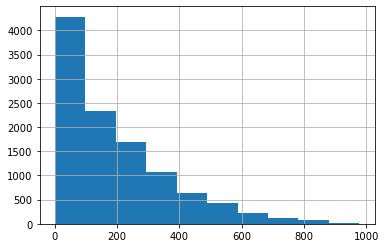

In [8]:
y_target.hist()

count 칼럼값이 0~200 에 치중되어 있다. 이렇게 왜곡된 값을 정규분포로 바꾸기 위해 로그 변환을 실행한다.

<AxesSubplot:>

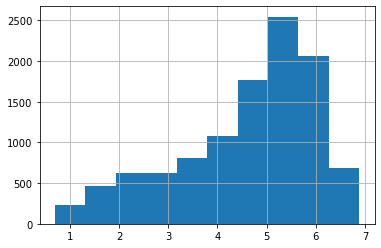

In [9]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

정규분포형태는 아니지만 많이 향상되었다. 변환된 타켓 값으로 평가를 수행한다.

In [10]:
y_target_log = np.log1p(y_target)

X_train,X_test,y_train,y_test = train_test_split(X_features,y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 로그 변환한 값을 원래 스케일로 변환한다.
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE:162.594, MAE:109.286


RMSLE 오류는 줄었지만 RMSE 오류는 증가했다. 각 피처의 회귀계수 값을 시각화 하겠다.

<AxesSubplot:>

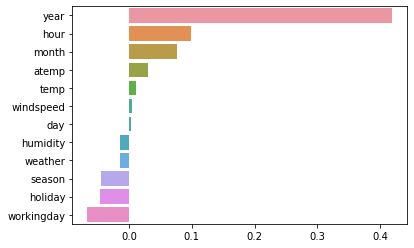

In [11]:
coef = pd.Series(lr_reg.coef_,index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

year 피처는 2011,2012로 구성되어 알고리즘이 중요 피처라고 판단했다. 이러한 카테고리형 피처는 선형 회귀를 사용할 때 회귀 계수를 연산할 때 영향을 많이 받는다. 따라서 원-핫 인코딩을 실행한다.

In [13]:
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

X_train,X_test,y_train,y_test = train_test_split(X_features_ohe, y_target_log,
                                                test_size=0.3, random_state=0)

def get_model_predict(model,X_train,X_test,y_train,y_test, is_expm1=False):
    model.fit(X_train,y_train)
    pred= model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred=np.expm1(pred)
        
    print("###",model.__class__.__name__,'###')
    evaluate_regr(y_test,pred)
    
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train,X_test, y_train,y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE:97.688, MAE:63.382
### Ridge ###
RMSLE: 0.590, RMSE:98.529, MAE:63.893
### Lasso ###
RMSLE: 0.635, RMSE:113.219, MAE:72.803


선형회귀 예측 능력이 많이 향상 되었다. 회귀 계수 상위 25개 피처를 추출한다.

<AxesSubplot:>

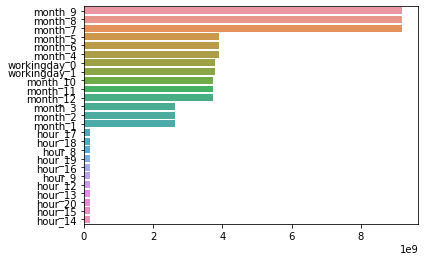

In [14]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort= coef.sort_values(ascending=False)[:25]
sns.barplot(x=coef_sort.values,y=coef_sort.index)

회귀 트리를 이용해 회귀 예측을 실행한다.

In [15]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values,
                     is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE:50.246, MAE:31.123
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE:53.337, MAE:32.743


/Users/wangjonghwi/anaconda3/envs/myML/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


### XGBRegressor ###
RMSLE: 0.342, RMSE:51.732, MAE:31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE:47.215, MAE:29.029
